<a href="https://colab.research.google.com/github/CodeChivalry/GPT-Neo-GPT-2/blob/main/dreaddit_gpt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
pip install transformers


In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

# Set seed for reproducibility.
set_seed(123)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 4

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 32

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {0: 0, 1: 1,}


# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

In [ ]:
class MovieReviewsDataset(Dataset):
    r"""PyTorch Dataset class for loading data.
    This is where the data parsing happens.
    This class is built with reusability in mind: it can be used as is as.
    """

    def __init__(self, path, use_tokenizer):
        # ... (previous code)

        for label in ['pos', 'neg']:
            sentiment_path = os.path.join(path, label)

            # Get all files from path.
            files_names = os.listdir(sentiment_path)
            for file_name in tqdm(files_names, desc=f'{label} files'):
                file_path = os.path.join(sentiment_path, file_name)

                # Read content.
                content = io.open(file_path, mode='r', encoding='utf-8').read()
                # Fix any unicode issues.
                content = fix_text(content)
                # Save content.
                self.texts.append(content)
                # Save encode labels.
                self.labels.append(label)  # Replace 'label' with 'Suicide'

        # Number of examples.
        self.n_examples = len(self.labels)
        return

    def __len__(self):
        return self.n_examples

    def __getitem__(self, item):
        return {'text': self.texts[item],  # Replace 'text' with 'tweet'
                'label': self.labels[item]}  # Replace 'label' with 'Suicide'



class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classification task.
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to
          labels names and Values map to a number associated with those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed, it will use the maximum sequence size
          supported by the tokenizer and model.
    """



    def __call__(self, sequences):
        r"""
        This function allows the class object to be used as a function call.
        Since the PyTorch DataLoader needs a collator function, I can use this
        class as a function.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]  # Replace 'text' with 'tweet'
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]  # Replace 'label' with 'Suicide'
        # Encode all labels using the label encoder.
        labels = [self.labels_encoder[label] for label in labels]  # Replace 'label' with 'Suicide'
        # Call tokenizer on all texts to convert into tensors of numbers with
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,
                                    max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as a tensor.
        inputs.update({'labels': torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here:
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading configuraiton...


Loading tokenizer...


Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [ ]:
import torch
import pandas as pd
from transformers import GPT2Tokenizer, GPTNeoForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import DataLoader

# Load the fine-tuned model and tokenizer
model = GPTNeoForSequenceClassification.from_pretrained('emotion_classification_model')
tokenizer = GPT2Tokenizer.from_pretrained('emotion_classification_tokenizer')
tokenizer.add_special_tokens({'pad_token': ''})  # Use an empty string as the padding token

# Read the dataset from the CSV file
dataset = pd.read_csv('dreaddit-train.csv')

# Load the validation dataset
# Assuming you have a DataFrame named val_df with "text" and "label" columns
val_dialogues = dataset['text'].tolist()
val_labels = dataset['label'].tolist()
val_encodings = tokenizer(val_dialogues, truncation=True, padding='max_length', max_length=64)

# Create a dataset for validation
class EmotionValidationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encodings['input_ids'][idx])
        attention_mask = torch.tensor(self.encodings['attention_mask'][idx])
        label = torch.tensor(self.labels[idx])
        return input_ids, attention_mask, label

    def __len__(self):
        return len(self.labels)

# Create the validation dataset
val_dataset = EmotionValidationDataset(val_encodings, val_labels)

# Create a DataLoader for the validation dataset
val_dataloader = DataLoader(val_dataset, batch_size=16)

# Put the model in evaluation mode
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = batch  # Unpack the batch into individual tensors
        input_ids = input_ids.to(model.device)
        attention_mask = attention_mask.to(model.device)
        labels = labels.to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()

        all_predictions.extend(predicted_labels.tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report for all classes
report = classification_report(all_labels, all_predictions, output_dict=True)

# Convert the report dictionary to a Pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Print the evaluation report as a table
print(report_df)

# Calculate overall precision, recall, and F1 score
overall_precision = report_df['precision'].mean()
overall_recall = report_df['recall'].mean()
overall_f1_score = report_df['f1-score'].mean()

print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1 Score: {overall_f1_score:.4f}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


OSError: ignored

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
from sklearn.preprocessing import LabelEncoder

# Define batch size
batch_size = 32  # You can adjust this as needed.

# Read the dataset from the CSV file
dataset = pd.read_csv('dreaddit-train.csv')

# Extract dialogue and emotion columns
dialogues = dataset['text'].apply(str).tolist()  # Ensure dialogues are strings
emotions = dataset['label'].tolist()

# Initialize a GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Select EOS token as the padding token
tokenizer.pad_token = tokenizer.eos_token

# Tokenize dialogues and encode emotions
tokenized_dialogues = tokenizer(dialogues, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
label_encoder = LabelEncoder()
encoded_emotions = torch.tensor(label_encoder.fit_transform(emotions), dtype=torch.long)

# Define a custom dataset class for emotion classification
class EmotionClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_dialogues, encoded_emotions):
        self.tokenized_dialogues = tokenized_dialogues
        self.encoded_emotions = encoded_emotions

    def __len__(self):
        return len(self.tokenized_dialogues["input_ids"])

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokenized_dialogues["input_ids"][idx],
            'attention_mask': self.tokenized_dialogues["attention_mask"][idx],
            'labels': self.encoded_emotions[idx]
        }

# Create the dataset for emotion classification
emotion_dataset = EmotionClassificationDataset(tokenized_dialogues, encoded_emotions)

print('Dealing with Train...')

# Create a dataloader for emotion classification
emotion_dataloader = DataLoader(emotion_dataset, batch_size=batch_size, shuffle=True)
print('Created `emotion_dataloader` with %d batches!' % len(emotion_dataloader))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dealing with Train...
Created `emotion_dataloader` with 89 batches!


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch


  0%|          | 0/10 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/89 [00:00<?, ?it/s]

  train_loss: 0.63970 - train_acc: 0.63777 


Training on batches...


  0%|          | 0/89 [00:00<?, ?it/s]

  train_loss: 0.49867 - train_acc: 0.75722 


Training on batches...


  0%|          | 0/89 [00:00<?, ?it/s]

  train_loss: 0.42576 - train_acc: 0.79986 


Training on batches...


  0%|          | 0/89 [00:00<?, ?it/s]

  train_loss: 0.36285 - train_acc: 0.83932 


Training on batches...


  0%|          | 0/89 [00:00<?, ?it/s]

  train_loss: 0.29432 - train_acc: 0.87984 


Training on batches...


  0%|          | 0/89 [00:00<?, ?it/s]

  train_loss: 0.22661 - train_acc: 0.90345 


Training on batches...


  0%|          | 0/89 [00:00<?, ?it/s]

  train_loss: 0.18936 - train_acc: 0.92812 


Training on batches...


  0%|          | 0/89 [00:00<?, ?it/s]

  train_loss: 0.13699 - train_acc: 0.95490 


Training on batches...


  0%|          | 0/89 [00:00<?, ?it/s]

  train_loss: 0.10364 - train_acc: 0.96335 


Training on batches...


  0%|          | 0/89 [00:00<?, ?it/s]

  train_loss: 0.09659 - train_acc: 0.96512 



/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


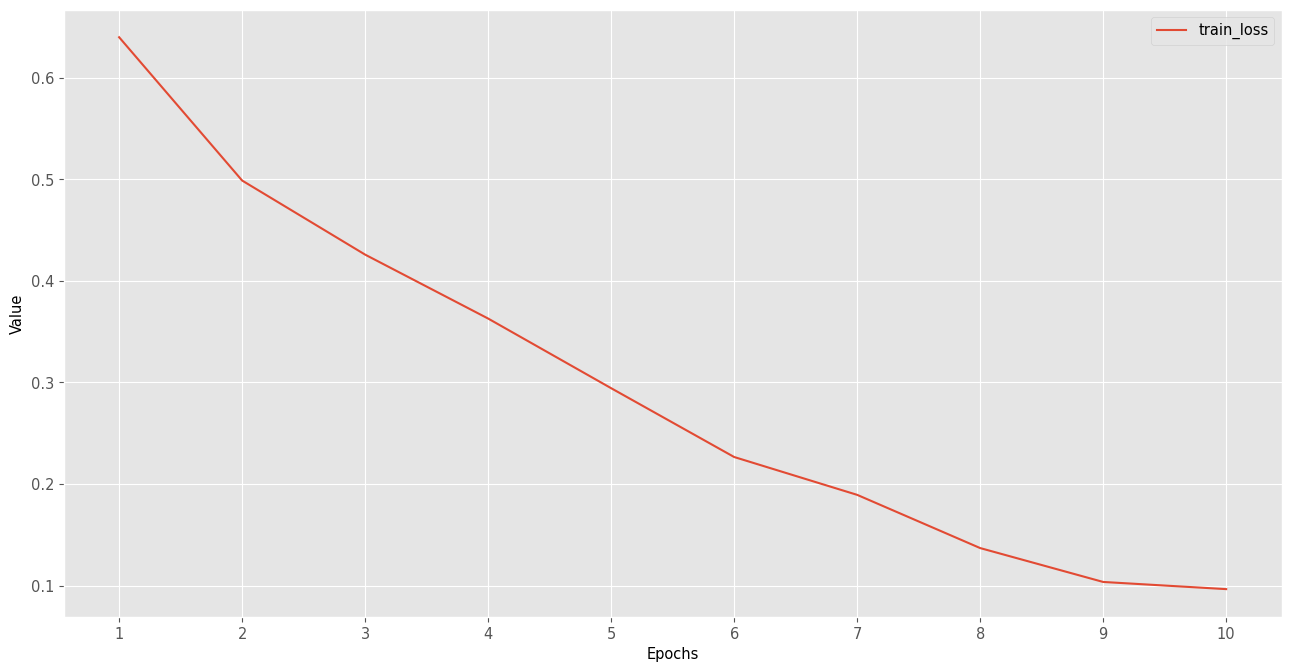

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


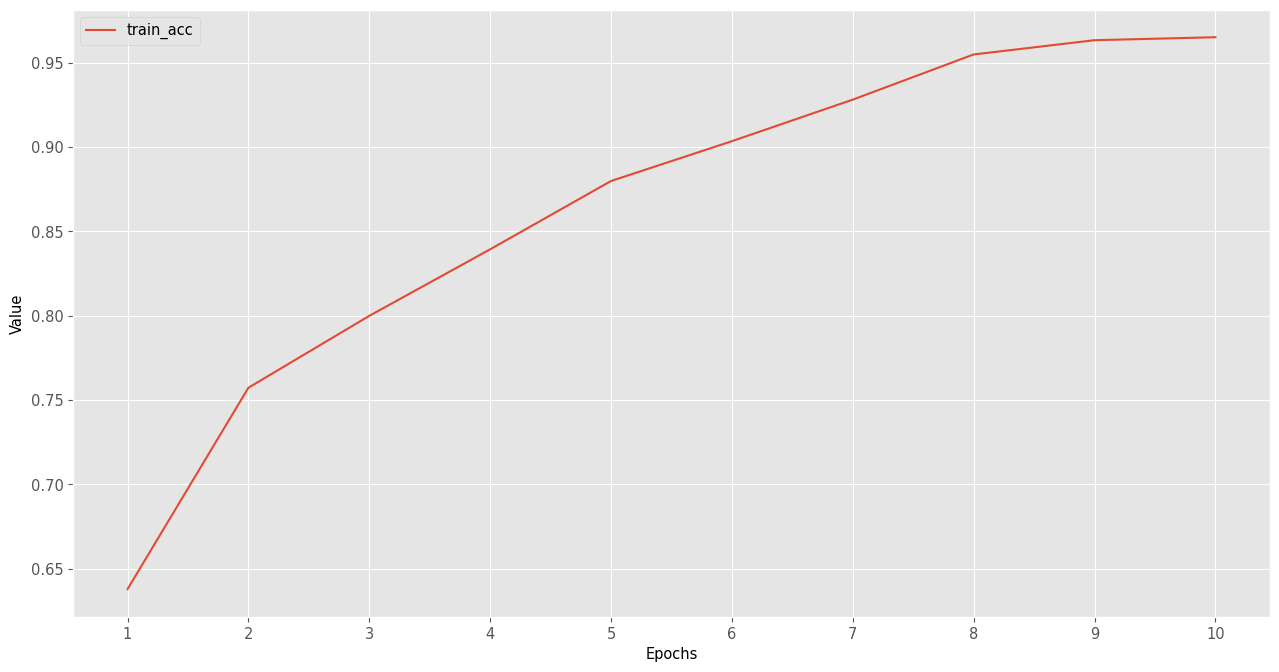

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
epochs = 10  # Train the model for 10 epochs

# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(emotion_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[]}
all_acc = {'train_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(emotion_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)


  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - train_acc: %.5f "%(train_loss, train_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)

  all_acc['train_acc'].append(train_acc)


# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
test_dataset = EmotionClassificationDataset(tokenized_test_dialogues, encoded_test_emotions)

# Create a dataloader for the test data
emotion_test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Set shuffle to False for testing

# Evaluate the model on the test data
true_labels, predicted_labels, test_loss = validation(emotion_test_dataloader, device)

# Calculate accuracy
test_accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Optionally, you can also generate a classification report
evaluation_report = classification_report(true_labels, predicted_labels, labels=[0, 1], target_names=["not stressed", "stressed"])
print(evaluation_report)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored

In [ ]:
import torch
import pandas as pd
from transformers import GPT2Tokenizer, GPTNeoForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import DataLoader

# Load the fine-tuned model and tokenizer
model = GPT2ForSequenceClassification.from_pretrained('emotion_dataloader')
tokenizer = GPT2Tokenizer.from_pretrained('emotion_dataloader')
tokenizer.add_special_tokens({'pad_token': ''})  # Use an empty string as the padding token

# Read the dataset from the CSV file
dataset = pd.read_csv('dreaddit-train.csv')

# Load the validation dataset
# Assuming you have a DataFrame named val_df with "text" and "label" columns
val_dialogues = dataset['text'].tolist()
val_labels = dataset['label'].tolist()
val_encodings = tokenizer(val_dialogues, truncation=True, padding='max_length', max_length=64)

# Create a dataset for validation
class EmotionValidationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encodings['input_ids'][idx])
        attention_mask = torch.tensor(self.encodings['attention_mask'][idx])
        label = torch.tensor(self.labels[idx])
        return input_ids, attention_mask, label

    def __len__(self):
        return len(self.labels)

# Create the validation dataset
val_dataset = EmotionValidationDataset(val_encodings, val_labels)

# Create a DataLoader for the validation dataset
val_dataloader = DataLoader(val_dataset, batch_size=16)

# Put the model in evaluation mode
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = batch  # Unpack the batch into individual tensors
        input_ids = input_ids.to(model.device)
        attention_mask = attention_mask.to(model.device)
        labels = labels.to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()

        all_predictions.extend(predicted_labels.tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report for all classes
report = classification_report(all_labels, all_predictions, output_dict=True)

# Convert the report dictionary to a Pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Print the evaluation report as a table
print(report_df)

# Calculate overall precision, recall, and F1 score
overall_precision = report_df['precision'].mean()
overall_recall = report_df['recall'].mean()
overall_f1_score = report_df['f1-score'].mean()

print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1 Score: {overall_f1_score:.4f}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


OSError: ignored

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report for all classes
report = classification_report(all_labels, all_predictions, output_dict=True)

# Convert the report dictionary to a Pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Print the evaluation report as a table
print(report_df)

# Calculate overall precision, recall, and F1 score
overall_precision = report_df['precision'].mean()
overall_recall = report_df['recall'].mean()
overall_f1_score = report_df['f1-score'].mean()

print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1 Score: {overall_f1_score:.4f}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Get prediction from the model on the test data
true_labels, predicted_labels, avg_epoch_loss = validation(emotion_dataloader, device)

# Calculate precision, recall, and F1 score for the entire model
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Show the evaluation metrics for the entire model
print(f"Weighted Average Precision: {precision:.4f}")
print(f"Weighted Average Recall: {recall:.4f}")
print(f"Weighted Average F1 Score: {f1:.4f}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get prediction from the model on the test data
true_labels, predicted_labels, avg_epoch_loss = validation(emotion_dataloader, device)

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision, recall, and F1 score for the entire model
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Show the evaluation metrics for the entire model
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Weighted Average Precision: {precision:.4f}")
print(f"Weighted Average Recall: {recall:.4f}")
print(f"Weighted Average F1 Score: {f1:.4f}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Get prediction from the model on the test data
true_labels, predicted_labels, avg_epoch_loss = validation(emotion_dataloader, device)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Create the evaluation report
class_names = ["not stressed", "stressed"]
evaluation_report = classification_report(true_labels, predicted_labels, labels=[0, 1], target_names=class_names, output_dict=True)

# Extract precision and recall for each class
precision_not_stressed = evaluation_report["not stressed"]["precision"]
precision_stressed = evaluation_report["stressed"]["precision"]
recall_not_stressed = evaluation_report["not stressed"]["recall"]
recall_stressed = evaluation_report["stressed"]["recall"]

# Print the evaluation report with accuracy, precision, and recall
print("\nEvaluation Report:")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Precision (not stressed): {precision_not_stressed:.4f}")
print(f"Precision (stressed): {precision_stressed:.4f}")
print(f"Recall (not stressed): {recall_not_stressed:.4f}")
print(f"Recall (stressed): {recall_stressed:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, labels=[0, 1], target_names=class_names))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/89 [00:00<?, ?it/s]

Confusion Matrix:
[[1340   10]
 [  36 1452]]

Evaluation Report:
Overall Accuracy: 0.9838
Precision (not stressed): 0.9738
Precision (stressed): 0.9932
Recall (not stressed): 0.9926
Recall (stressed): 0.9758

Classification Report:
              precision    recall  f1-score   support

not stressed       0.97      0.99      0.98      1350
    stressed       0.99      0.98      0.98      1488

    accuracy                           0.98      2838
   macro avg       0.98      0.98      0.98      2838
weighted avg       0.98      0.98      0.98      2838



In [ ]:

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get prediction from the model on the test data
true_labels, predicted_labels, avg_epoch_loss = validation(emotion_dataloader, device)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Create the evaluation report
class_names = ["not stressed", "stressed"]
evaluation_report = classification_report(true_labels, predicted_labels, labels=[0, 1], target_names=class_names, output_dict=True)

# Extract precision and recall for each class
precision_not_stressed = evaluation_report["not stressed"]["precision"]
precision_stressed = evaluation_report["stressed"]["precision"]
recall_not_stressed = evaluation_report["not stressed"]["recall"]
recall_stressed = evaluation_report["stressed"]["recall"]

# Print the evaluation report with accuracy, precision, and recall
print("\nEvaluation Report:")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Precision (not stressed): {precision_not_stressed:.4f}")
print(f"Precision (stressed): {precision_stressed:.4f}")
print(f"Recall (not stressed): {recall_not_stressed:.4f}")
print(f"Recall (stressed): {recall_stressed:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, labels=[0, 1], target_names=class_names))

# Plot the confusion matrix
disp = plot_confusion_matrix(model, emotion_dataloader, true_labels=true_labels, display_labels=class_names, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/89 [00:00<?, ?it/s]

Confusion Matrix:
[[1340   10]
 [  36 1452]]

Evaluation Report:
Overall Accuracy: 0.9838
Precision (not stressed): 0.9738
Precision (stressed): 0.9932
Recall (not stressed): 0.9926
Recall (stressed): 0.9758

Classification Report:
              precision    recall  f1-score   support

not stressed       0.97      0.99      0.98      1350
    stressed       0.99      0.98      0.98      1488

    accuracy                           0.98      2838
   macro avg       0.98      0.98      0.98      2838
weighted avg       0.98      0.98      0.98      2838



TypeError: ignored

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


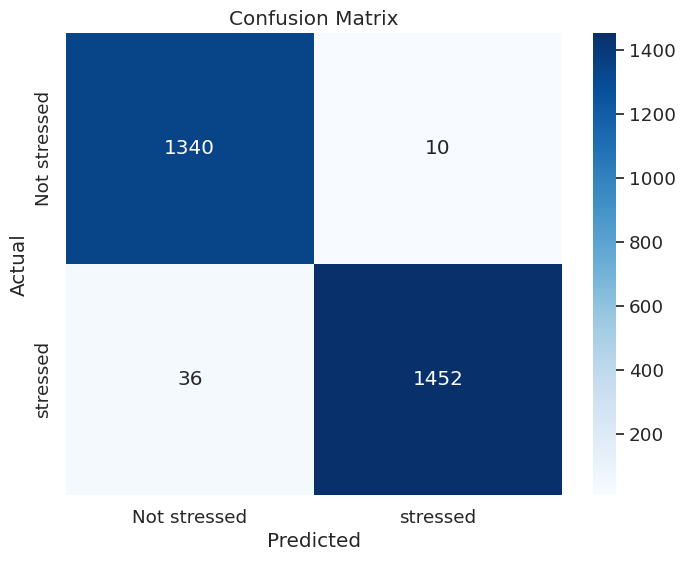

In [ ]:
import torch
import pandas as pd
from transformers import GPT2Tokenizer, GPTNeoForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
# Define class labels
class_labels = ['Not stressed', 'stressed']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better visibility
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/89 [00:00<?, ?it/s]

              precision    recall  f1-score   support

not stressed       0.97      0.99      0.98      1350
    stressed       0.99      0.98      0.98      1488

    accuracy                           0.98      2838
   macro avg       0.98      0.98      0.98      2838
weighted avg       0.98      0.98      0.98      2838

Normalized confusion matrix


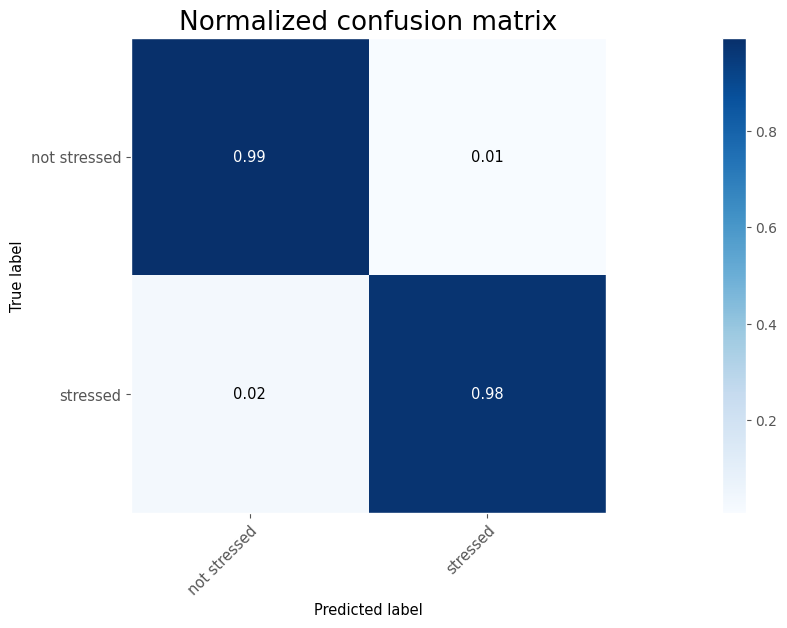

array([[0.99259259, 0.00740741],
       [0.02419355, 0.97580645]])

In [ ]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(emotion_dataloader, device)


# Create the evaluation report with "non-depressed" and "depressed"
evaluation_report = classification_report(true_labels, predictions_labels, labels=[0, 1], target_names=["not stressed", "stressed"])

# Show the evaluation report
print(evaluation_report)

# Plot confusion matrix with class names
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels,
                      classes=["not stressed", "stressed"], normalize=True,
                      magnify=0.1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/89 [00:00<?, ?it/s]

Evaluation Report:
Overall Accuracy: 0.9838
Precision (not stressed): 0.9738
Precision (stressed): 0.9932
Recall (not stressed): 0.9926
Recall (stressed): 0.9758

Classification Report:
              precision    recall  f1-score   support

not stressed       0.97      0.99      0.98      1350
    stressed       0.99      0.98      0.98      1488

    accuracy                           0.98      2838
   macro avg       0.98      0.98      0.98      2838
weighted avg       0.98      0.98      0.98      2838

Normalized confusion matrix


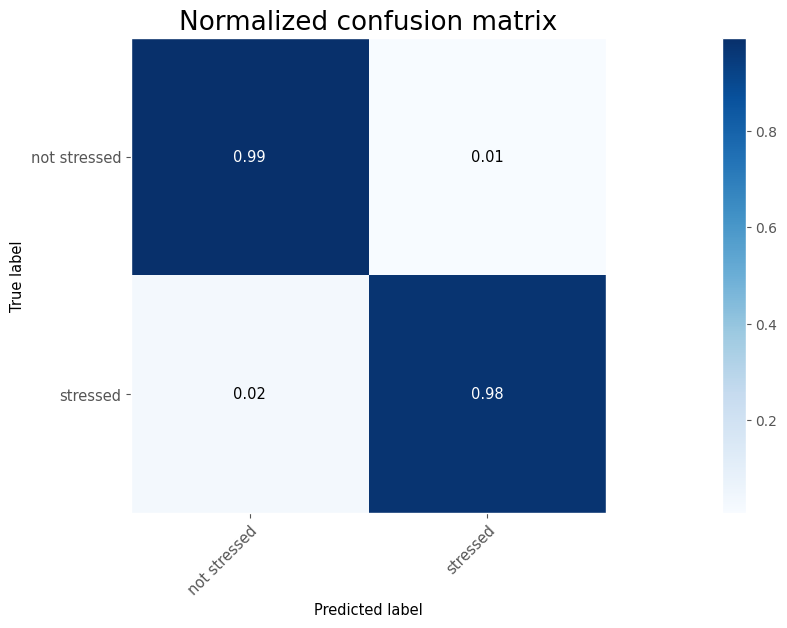

array([[0.99259259, 0.00740741],
       [0.02419355, 0.97580645]])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Get prediction from the model on the test data
true_labels, predicted_labels, avg_epoch_loss = validation(emotion_dataloader, device)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Create the evaluation report
class_names = ["not stressed", "stressed"]
evaluation_report = classification_report(true_labels, predicted_labels, labels=[0, 1], target_names=class_names, output_dict=True)

# Extract precision and recall for each class
precision_not_stressed = evaluation_report["not stressed"]["precision"]
precision_stressed = evaluation_report["stressed"]["precision"]
recall_not_stressed = evaluation_report["not stressed"]["recall"]
recall_stressed = evaluation_report["stressed"]["recall"]

# Print the evaluation report with accuracy, precision, and recall
print("Evaluation Report:")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Precision (not stressed): {precision_not_stressed:.4f}")
print(f"Precision (stressed): {precision_stressed:.4f}")
print(f"Recall (not stressed): {recall_not_stressed:.4f}")
print(f"Recall (stressed): {recall_stressed:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, labels=[0, 1], target_names=class_names))

# Plot the confusion matrix
plot_confusion_matrix(y_true=true_labels, y_pred=predicted_labels,
                      classes=class_names, normalize=True, magnify=0.1)


In [ ]:
# Map class labels to the desired names
class_labels = ["Not depressed", "Depressed"]

# Create the evaluation report
evaluation_report = classification_report(true_labels, predictions_labels, target_names=class_labels)

# Print the evaluation report
print(evaluation_report)

               precision    recall  f1-score   support

Not depressed       0.97      0.99      0.98      1350
    Depressed       0.99      0.98      0.98      1488

     accuracy                           0.98      2838
    macro avg       0.98      0.98      0.98      2838
 weighted avg       0.98      0.98      0.98      2838



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Map class labels to the desired names
class_labels = ["Not depressed", "Depressed"]

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions_labels)

# Calculate precision and recall
precision = precision_score(true_labels, predictions_labels, average='weighted')
recall = recall_score(true_labels, predictions_labels, average='weighted')

# Print accuracy, precision, and recall
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Create the evaluation report
evaluation_report = classification_report(true_labels, predictions_labels, target_names=class_labels)

# Print the evaluation report
print(evaluation_report)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored